In [55]:
import os
import random
import numpy as np
from scipy.io import wavfile

# Function to add lag (in seconds) and reduce power
def process_signal(signal, sample_rate, lag_seconds=0.05, power_reduction_db=-20):
    power_reduction = 10 ** (power_reduction_db / 20)
    processed_signal = signal * power_reduction
    lag_samples = int(lag_seconds * sample_rate)
    processed_signal = np.pad(processed_signal, (lag_samples, 0), mode='constant')
    return processed_signal

# Function to mix multiple signals
def mix_signals(signals):
    max_length = max([len(signal) for signal in signals])
    mixed_signal = np.zeros(max_length)
    for signal in signals:
        padded_signal = np.pad(signal, (0, max_length - len(signal)), mode='constant')
        mixed_signal += padded_signal
    return mixed_signal

# Function to load .wav files
def load_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data

def save_wav(file_path, sample_rate, data):
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

# Function to load multiple .wav files from a folder
def load_wav_files_from_folder(folder_path, limit=None):
    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    loaded_signals = []
    for file in wav_files[:limit]:
        sample_rate, data = load_wav(file)
        loaded_signals.append(data)
    return sample_rate, loaded_signals

# Function to simulate the test signal by adding lag, reducing power, and mixing multiple additional speeches
def simulate_test_signal(folder_path, output_path, main_path, lag_seconds=0.05, power_reduction_db=-6, n_amp = 1):
    # List all .wav files in the folder
    wav_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

    #sample_rate, test_noise = load_wav(tnoise_path)
    #sample_rate, error_noise = load_wav(enoise_path)

    # Randomly select a file as the test signal
    test_signal_file = random.choice(wav_files)
    remaining_files = [file for file in wav_files if file != test_signal_file]

    # Load primary test signal (to be filtered)
    sample_rate, test_signal = load_wav(test_signal_file)
    print(f"Test Signal: {test_signal_file}")

    # Load additional speech signals from the remaining files
    sample_rate, additional_speeches = load_wav_files_from_folder(folder_path, limit=20)

    # Add lag and reduce power for the test signal
    processed_test_signal = process_signal(test_signal, sample_rate, lag_seconds, power_reduction_db)

    # Mix all the additional speech signals
    additional_speech_mixed = mix_signals(additional_speeches)

    length = len(test_signal)

    test_noise = 2 * n_amp * (np.random.random(length) - 0.5)
    error_noise = 2 * n_amp * (np.random.random(length) - 0.5)

    # Mix the processed test signal with the additional speech noise
    final_signal = mix_signals([processed_test_signal, additional_speech_mixed, error_noise])
    test_signal1 = mix_signals([test_signal, test_noise, additional_speech_mixed])

    # Save the mixed signal as a .wav file
    save_wav(output_path, sample_rate, final_signal)
    save_wav(main_path, sample_rate, test_signal1)
    save_wav(original_path, sample_rate, test_signal)
    print(f"Processed and mixed signal saved to {output_path}")

# Relative paths to the folder and output file
folder_path = './sample_data/original'
#tnoise_path = './sample_data/modified/test_noise.wav'
#enoise_path = './sample_data/modified/error_noise.wav'
output_path = './sample_data/modified/error_signal.wav'
main_path = './sample_data/modified/main_signal.wav'
original_path = './sample_data/modified/orig_signal.wav'

# Simulate the test signal
simulate_test_signal(folder_path, output_path, main_path, lag_seconds=0.05, power_reduction_db=-6, n_amp = 1)

Test Signal: ./sample_data/original\OSR_us_000_0061_8k.wav
Processed and mixed signal saved to ./sample_data/modified/error_signal.wav


In [59]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import lfilter, butter, filtfilt

# Constants
NUM_HARMONICS = 40  # Number of harmonics to decompose
STEP_SIZE = 0.005  # FXNLMS step size
WINDOW_SIZE = 960  # Window size for F0 estimation (20ms window)

# Function to read .wav file
def read_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    return sample_rate, data.astype(np.float32)

# Function to save .wav file
def save_wav(file_path, sample_rate, data):
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

def autocorrelation(signal, sample_rate):
    """Estimate fundamental frequency using autocorrelation method."""
    corr = np.correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]  # Use positive lags
    d = np.diff(corr)
    start = np.where(d > 0)[0][0]  # First positive difference
    peak = np.argmax(corr[start:]) + start
    f0 = sample_rate / peak if peak > 0 else 200
    return f0

def harmonic_decomposition(signal, f0, sampling_rate, num_harmonics):
    """Decompose signal into harmonic components."""
    harmonics = []
    omega_0 = 2 * np.pi * f0 / sampling_rate
    for l in range(1, num_harmonics + 1):
        harmonic = np.cos(l * omega_0 * np.arange(len(signal)))
        harmonics.append(harmonic)
    return np.array(harmonics)

def quadrature_harmonics(harmonics):
    """Generate quadrature harmonics (90-degree phase shift)."""
    return np.sin(np.angle(harmonics))

def fxnlms_update(harmonics, quadrature, error_signal, weights, step_size):
    """Update FXNLMS weights for harmonics and their quadrature components."""
    num_harmonics = harmonics.shape[0]
    for l in range(num_harmonics):
        # Update for both harmonic and quadrature components
        weights[0, l] += step_size * np.sum(error_signal * harmonics[l])
        weights[1, l] += step_size * np.sum(error_signal * quadrature[l])
    return weights

def generate_anti_noise(harmonics, quadrature, weights, length):
    """Generate anti-noise signal using weighted harmonics and quadrature."""
    anti_noise = np.zeros(length)
    for l in range(harmonics.shape[0]):
        anti_noise += weights[0, l] * harmonics[l] + weights[1, l] * quadrature[l]
    return anti_noise

def process_wav_files(input_wav, error_wav, output_wav):
    # Initialize weights for the FXNLMS adaptive filter
    weights = np.zeros((2, NUM_HARMONICS))  # Separate weights for harmonics and quadrature components
    
    # Load input and error .wav files
    sample_rate, input_signal = read_wav(input_wav)
    _, error_signal = read_wav(error_wav)

    # Ensure both signals are the same length
    min_len = min(len(input_signal), len(error_signal))
    input_signal = input_signal[:min_len]
    error_signal = error_signal[:min_len]

    # Apply bandpass filter
    b, a = butter(4, [50/24000, 2000/24000], btype='band')
    input_signal = filtfilt(b, a, input_signal)

    # Estimate fundamental frequency using autocorrelation on a 20ms window
    f0 = autocorrelation(input_signal[:WINDOW_SIZE], sample_rate)

    # Harmonic decomposition
    harmonics = harmonic_decomposition(input_signal, f0, sample_rate, NUM_HARMONICS)
    quadrature = quadrature_harmonics(harmonics)

    # FXNLMS adaptive filtering update
    weights = fxnlms_update(harmonics, quadrature, error_signal, weights, STEP_SIZE)

    # Generate anti-noise signal
    anti_noise = generate_anti_noise(harmonics, quadrature, weights, len(input_signal))

    # Save the anti-noise signal to output .wav
    save_wav(output_wav, sample_rate, anti_noise)

# Example usage with .wav files
process_wav_files('./sample_data/modified/main_signal.wav', 
                 './sample_data/modified/error_signal.wav', 
                 './sample_data/modified/output_anti_noise.wav')

In [60]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, filtfilt

# Constants
RATE = 48000  # Sampling rate in Hz
CHUNK = 1024
STEP_SIZE = 0.01

def load_wav(file_path):
    sample_rate, data = wavfile.read(file_path)
    data = data.astype(np.float32)
    if np.max(np.abs(data)) > 0:
        data = data / np.max(np.abs(data))
    return sample_rate, data

def save_wav(file_path, sample_rate, data):
    max_val = np.max(np.abs(data))
    if max_val > 0:
        data = data * (32767 / max_val)
    wavfile.write(file_path, sample_rate, data.astype(np.int16))

def fxlms_anc(test_signal, error_signal, step_size=STEP_SIZE):
    filter_length = 512
    delay = 50
    
    test_signal = test_signal - np.mean(test_signal)
    error_signal = error_signal - np.mean(error_signal)
    
    b, a = butter(4, [50/24000, 2000/24000], btype='band')
    test_signal = filtfilt(b, a, test_signal)
    
    w = np.zeros(filter_length)
    x_buffer = np.zeros(filter_length)
    output_signal = np.zeros_like(test_signal)
    
    power = np.zeros_like(test_signal)
    beta = 0.999
    
    for i in range(delay, len(test_signal)):
        x_buffer = np.roll(x_buffer, 1)
        x_buffer[0] = test_signal[i]
        
        power[i] = beta * power[i-1] + (1-beta) * x_buffer[0]**2
        mu = step_size / (power[i] + 1e-6)
        
        output_signal[i] = -np.dot(w, x_buffer)
        
        e = error_signal[i] + output_signal[i]
        
        w = w + mu * e * x_buffer
        w = np.clip(w, -1, 1)
    
    return output_signal

def compare_anc_performance(test_signal_path, error_signal_path, output_ref_path, output_hmd_path):
    # Load signals
    sample_rate, test_signal = load_wav(test_signal_path)
    _, error_signal = load_wav(error_signal_path)
    
    # Ensure signals are the same length
    min_len = min(len(test_signal), len(error_signal))
    test_signal = test_signal[:min_len]
    error_signal = error_signal[:min_len]
    
    # Reference ANC - FXLMS
    ref_anc_output = fxlms_anc(test_signal, error_signal)
    
    # Load HMD-ANC result
    _, hmd_anc_output = load_wav(output_hmd_path)
    hmd_anc_output = hmd_anc_output[:min_len]
    
    # Save reference ANC output
    save_wav(output_ref_path, sample_rate, ref_anc_output)
    
    # Compute error reduction in dB
    original_power = np.mean(error_signal**2)
    ref_residual_power = np.mean((error_signal - ref_anc_output)**2)
    hmd_residual_power = np.mean((error_signal - hmd_anc_output)**2)
    
    ref_reduction_db = 10 * np.log10(original_power / ref_residual_power)
    hmd_reduction_db = 10 * np.log10(original_power / hmd_residual_power)
    
    print("Performance Comparison:")
    print(f"FXLMS Noise Reduction: {ref_reduction_db:.2f} dB")
    print(f"HMD-ANC Noise Reduction: {hmd_reduction_db:.2f} dB")

# Paths to input and output files
test_signal_path = './sample_data/modified/main_signal.wav'
error_signal_path = './sample_data/modified/error_signal.wav'
output_ref_path = './sample_data/modified/output_ref_anc.wav'
output_hmd_path = './sample_data/modified/output_anti_noise.wav'

# Run the comparison
compare_anc_performance(test_signal_path, error_signal_path, output_ref_path, output_hmd_path)

Performance Comparison:
FXLMS Noise Reduction: -49.02 dB
HMD-ANC Noise Reduction: -9.93 dB


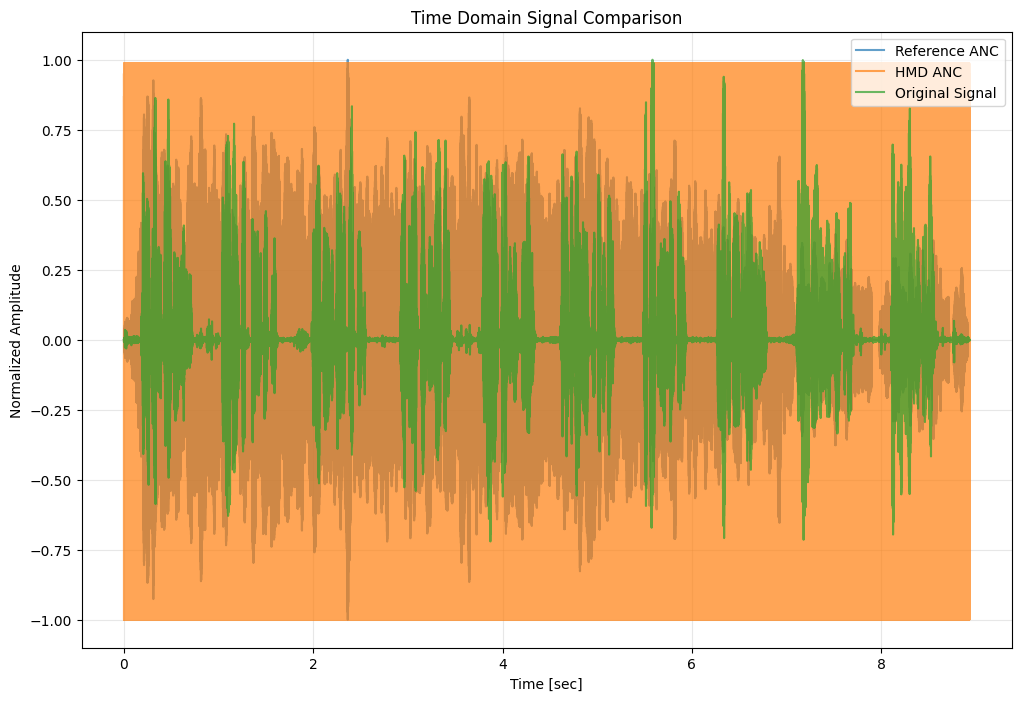


Performance Metrics:
Mean Square Normalized Error (Reference ANC): 19.3326
Mean Square Normalized Error (HMD ANC): 44.3040
Noise Reduction (Reference ANC): -12.86 dB
Noise Reduction (HMD ANC): -16.46 dB


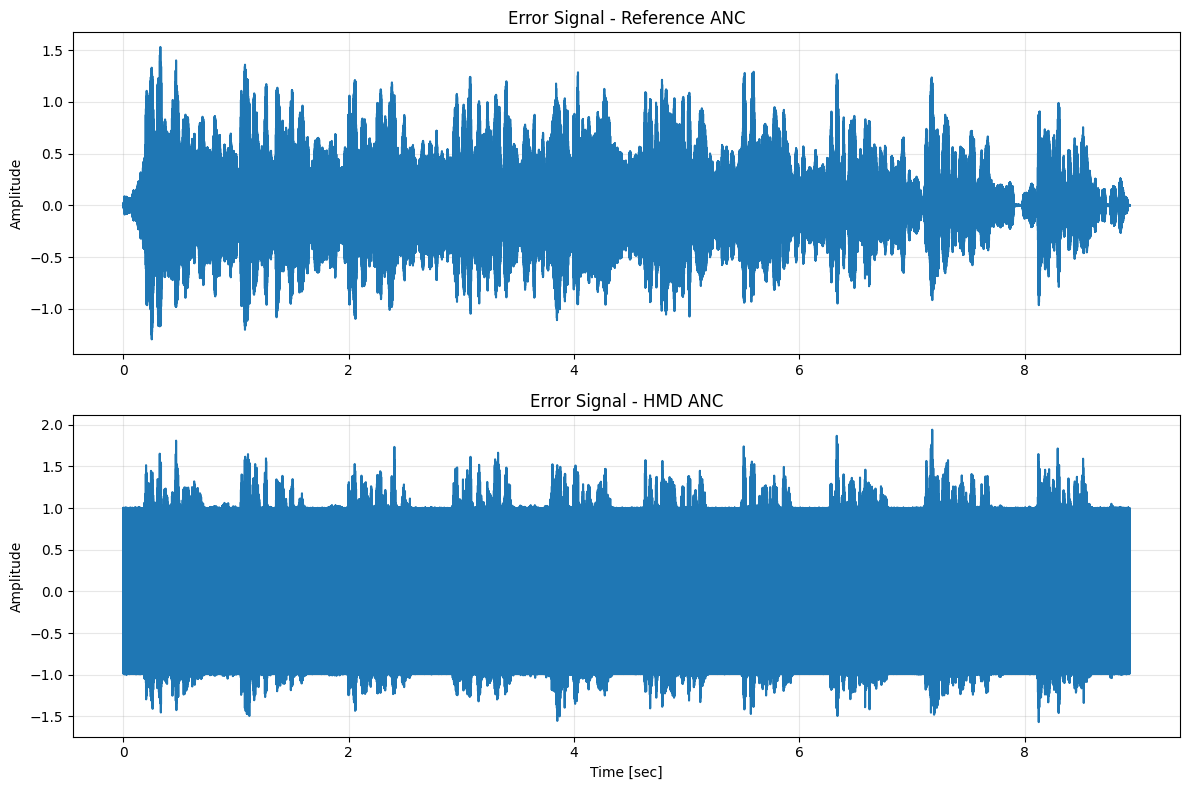

In [61]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

def analyze_signals(ref_path, hmd_path, orig_path, sample_rate):
    """
    Analyze and compare different ANC outputs with proper normalization and error calculation
    """
    # Load signals and convert to float32 for consistent processing
    signals = []
    for path in [ref_path, hmd_path, orig_path]:
        rate, signal = wavfile.read(path)
        signal = signal.astype(np.float32)
        # Normalize to [-1, 1] range
        if np.max(np.abs(signal)) > 0:
            signal = signal / np.max(np.abs(signal))
        signals.append(signal)
    
    # Ensure all signals are of the same length
    min_len = min(len(s) for s in signals)
    signals = [s[:min_len] for s in signals]
    
    # Plot time domain comparison
    plt.figure(figsize=(12, 8))
    time = np.linspace(0, min_len / sample_rate, min_len)
    labels = ['Reference ANC', 'HMD ANC', 'Original Signal']
    
    for signal, label in zip(signals, labels):
        plt.plot(time, signal, label=label, alpha=0.7)
    
    plt.ylabel('Normalized Amplitude')
    plt.xlabel('Time [sec]')
    plt.title('Time Domain Signal Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate proper MSNE (Mean Square Normalized Error)
    # MSNE = E[(e(n))^2] / E[(d(n))^2]
    # where e(n) is the error signal and d(n) is the desired (original) signal
    orig_power = np.mean(signals[2] ** 2)
    
    msne_ref = np.mean((signals[2] - signals[0]) ** 2) / (orig_power + 1e-10)
    msne_hmd = np.mean((signals[2] - signals[1]) ** 2) / (orig_power + 1e-10)
    
    # Calculate noise reduction in dB
    nr_ref = -10 * np.log10(msne_ref + 1e-10)
    nr_hmd = -10 * np.log10(msne_hmd + 1e-10)
    
    print("\nPerformance Metrics:")
    print(f"Mean Square Normalized Error (Reference ANC): {msne_ref:.4f}")
    print(f"Mean Square Normalized Error (HMD ANC): {msne_hmd:.4f}")
    print(f"Noise Reduction (Reference ANC): {nr_ref:.2f} dB")
    print(f"Noise Reduction (HMD ANC): {nr_hmd:.2f} dB")
    
    # Plot error signals
    plt.figure(figsize=(12, 8))
    error_ref = signals[2] - signals[0]
    error_hmd = signals[2] - signals[1]
    
    plt.subplot(2, 1, 1)
    plt.plot(time, error_ref)
    plt.title('Error Signal - Reference ANC')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(time, error_hmd)
    plt.title('Error Signal - HMD ANC')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage
RATE = 48000  # Your sampling rate
signal_paths = {
    'ref': './sample_data/modified/output_ref_anc.wav',
    'hmd': './sample_data/modified/output_anti_noise.wav',
    'orig': './sample_data/modified/orig_signal.wav'
}

analyze_signals(signal_paths['ref'], signal_paths['hmd'], signal_paths['orig'], RATE)